**Notebook Setup**

Before starting we need to give this notebook access to the git repository.

Use the left sidebar to upload a private key and name the file "id_rsa_REPO_NAME" (replacing REPO_NAME with the Github repository name). If you've not yet generated a key, you can do so with the command `ssh-keygen -f id_rsa_REPO_NAME -q -N ""` in a terminal (if you don't have access to a terminal you can run the command directly in this notebook by preceding it with a `!`). Save a copy of your private key, you will need to upload it again every time Google shuts down your session. The corresponding public key should be added as a "deploy key" to the repository (under the repo settings on Github).

You should treat these private keys as disposable passwords to your Github repo. Do not reuse keys between repos (but it may be convienient to share them with trusted collaborators).

In [ ]:
# Set your repository name here.
REPO_NAME = "hello-world-kiyo-masui"
ORG_NAME = "mit-8-942-2020"

In [ ]:
# This handy cell generates a new key pair and downloads them, should you need it.
from os import path
keyfile = "/content/id_rsa_%s" % REPO_NAME
if not path.exists(keyfile):
    !ssh-keygen -f {keyfile} -q -N ""
    print("Add this deploy key to repo:")
    !cat {keyfile}.pub
    from google.colab import files
    files.download(keyfile)
    files.download(keyfile + ".pub")

In [ ]:
# This is some basic setup of the authentication proceedure.
!chmod 600 id_rsa_{REPO_NAME}
%env GIT_SSH_COMMAND=ssh -i /content/id_rsa_{REPO_NAME} -o IdentitiesOnly=yes -F /dev/null -o StrictHostKeyChecking=no
# Clone (download) the repo.
!git clone git@github.com:{ORG_NAME}/{REPO_NAME}.git
# Enter the repo directory and install the software, including dependecies.
%cd {REPO_NAME}
!pip install .

After the above, the code should be all set up. You can now import and use it, interact with the repo using git, and run the tests.

In [1]:
# This sets how figures will be displayed.
%matplotlib inline

# Import libraries we will use
import numpy as np
import matplotlib.pyplot as plt

from expansion_fitter import fitters

In [ ]:
%ls
!git status

In [ ]:
!python -m pytest

In [ ]:
# After pulling a new version of the code you need to reload it.
!git pull
import importlib
importlib.reload(fitters)

In [2]:
# I'm going to fit a linear model (a straight line) using non-linear techniques.
# Then add in a twist: add a direct measurement of the slope of the line,
# which makes the data hetrogenious.


# Normal x-y data.
x = np.array([1., 3., 4., 6., 7.])
y_measured = np.array([-1.2, 1.86, 1.47, 4.37, 4.74])
y_error = np.array([1.00, 0.60, 0.50, 0.41, 0.38])

# Direct slope measurement.
slope_measured = 0.828
slope_measured_error = 0.060

In [3]:
# First do the fit without the direct slope measurement
fitter1 = fitters.LineFitter(x, y_measured, y_error)
pars_est1, covariance1 = fitter1.fit([1, 1])
errors1 = np.sqrt(np.diagonal(covariance1))

# Now with the direct slope constraint
fitter2 = fitters.LineFitterWithSlopeMeasurement(x, y_measured, y_error, slope_measured, slope_measured_error)
pars_est2, covariance2 = fitter2.fit([1, 1])
errors2 = np.sqrt(np.diagonal(covariance2))

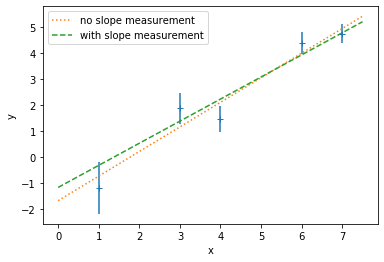

In [4]:
# Plots of the data and best fit lines for both fits.

def line(slope, offset, x):
    """y = mx + b"""
    return slope * x + offset

# Plot the data
plt.errorbar(x, y_measured, y_error, linestyle='', marker='+')
plt.xlabel("x")
plt.ylabel("y")
# Add best fit lines to our plot.
x_range = np.array([0, 7.5])
plt.plot(x_range, line(pars_est1[0], pars_est1[1], x_range), linestyle=':',
         label="no slope measurement")
plt.plot(x_range, line(pars_est2[0], pars_est2[1], x_range), linestyle='--',
         label="with slope measurement")
plt.legend()


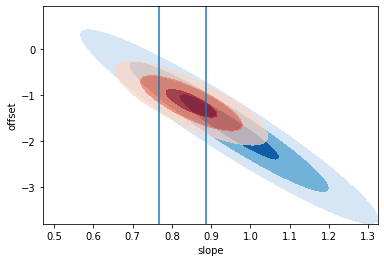

In [5]:
# Plots of the parameter space constraints for both fits

# Create arrays of parameter-space location offsets from best fit.
delta_par_slope, delta_par_offset = np.meshgrid(
        np.linspace(-3 * errors1[0], 3 * errors1[0], 100),
        np.linspace(-3 * errors1[1], 3 * errors1[1], 100),
        )

# Calculate how far each point in parameter space is from the best fit location.
nsigmas = np.array([[ fitters.n_signmas_pars(delta_par_slope[ii, jj], delta_par_offset[ii, jj], covariance1)
                   for ii in range(len(delta_par_slope)) ] for jj in range(len(delta_par_offset)) ])
plt.figure(1)
plt.contourf(
        delta_par_slope + pars_est1[0],
        delta_par_offset + pars_est1[1],
        # Negative sign just to reverse the colormap.
        -nsigmas,
        levels=-np.array([-0.1, 1, 2, 3])[::-1],
        cmap=plt.cm.Blues,
        )
plt.xlabel("slope")
plt.ylabel("offset")


plt.axvline(slope_measured - slope_measured_error)
plt.axvline(slope_measured + slope_measured_error)

nsigmas = np.array([[ fitters.n_signmas_pars(delta_par_slope[ii, jj], delta_par_offset[ii, jj], covariance2)
                   for ii in range(len(delta_par_slope)) ] for jj in range(len(delta_par_offset)) ])
plt.figure(1)
plt.contourf(
        delta_par_slope + pars_est2[0],
        delta_par_offset + pars_est2[1],
        # Negative sign just to reverse the colormap.
        -nsigmas,
        levels=-np.array([-0.1, 1, 2, 3])[::-1],
        cmap=plt.cm.Reds,
        alpha=0.7
        )

